# Decision Trees

# Agenda

1. FSM and Metric Discussion
2. Decision Trees at a High Level
3. ASM (Attribute Selection Methods): Entropy/Information Gain and Gini
4. Issues with Decision Trees: Overfitting, sensitivity to training data, greediness
5. Feature Importances
6. Grid Search

In [1]:
import pandas as pd
import numpy as np

# This is always a good idea
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from src.student_caller import one_random_student, pairs

import warnings
warnings.filterwarnings('ignore')

mccalister = ['Adam', 'Amanda','Chum', 'Dann',
 'Jacob', 'Jason', 'Johnhoy', 'Karim',
'Leana','Luluva', 'Matt', 'Maximilian','Syd' ]

# FSM and Metric Discussion

In [ ]:
# import requests
# import json

# response = requests.get('https://data.austintexas.gov/resource/9t4d-g238.json')
# animal_shelter = pd.DataFrame(response.json())

In [66]:
animal_shelter = pd.read_csv('data/austin.csv')

In [67]:
animal_shelter.set_index('Unnamed: 0', inplace=True)

In [68]:
from src.shelter_preprocess import preprocess_df

In [69]:
animal_shelter.age_upon_outcome.isna().sum()
animal_shelter.head()

,animal_id,datetime,monthyear,date_of_birth,outcome_type,outcome_subtype,animal_type,sex_upon_outcome,age_upon_outcome,breed,color,name
Unnamed: 0,,,,,,,,,,,,
0,A819400,2020-06-28T08:22:00.000,2020-06-28T08:22:00.000,2018-06-27T00:00:00.000,Euthanasia,Suffering,Other,Unknown,2 years,Squirrel,Brown/White,NaN
1,A819025,2020-06-27T15:26:00.000,2020-06-27T15:26:00.000,2020-05-12T00:00:00.000,Died,In Foster,Cat,Intact Female,1 month,Domestic Shorthair Mix,Blue Tabby,*Eloise
2,A818693,2020-06-27T14:21:00.000,2020-06-27T14:21:00.000,2020-02-12T00:00:00.000,Adoption,NaN,Cat,Spayed Female,4 months,Domestic Shorthair,Orange Tabby,*Aislinn
3,A809756,2020-06-27T12:43:00.000,2020-06-27T12:43:00.000,2018-11-30T00:00:00.000,Adoption,NaN,Dog,Spayed Female,1 year,Labrador Retriever/Pit Bull,Brown/Tricolor,Roxy
4,A819382,2020-06-27T10:19:00.000,2020-06-27T10:19:00.000,2018-06-27T00:00:00.000,Euthanasia,Suffering,Other,Unknown,2 years,Raccoon,Gray/Black,NaN


In [70]:
animal_shelter.dropna(subset=['age_upon_outcome'], inplace=True )
df = preprocess_df(animal_shelter)

df.shape

(903, 4)

In [71]:
df.head()

,is_dog,age_in_days,is_female,adoption
Unnamed: 0,,,,
1,0,46,1,0
2,0,136,1,1
3,1,575,1,1
5,0,748,1,0
6,0,75,0,1


In [72]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [73]:
X = df.drop(['adoption'], axis=1)
y = df.adoption

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size = .2)
X_train.head()
X_train.shape

(722, 3)

In [12]:
X_t, X_val, y_t, y_val = train_test_split(X_train,y_train, random_state=42, test_size = .25)
X_t.head()

,is_dog,age_in_days,is_female
Unnamed: 0,,,
301,1,1115,1
2,0,136,1
255,1,1162,1
139,0,2567,1
947,1,1827,1


In [13]:
dt = DecisionTreeClassifier()
dt.fit(X_t, y_t)
y_hat_val = dt.predict(X_val)
print(f'Training Score: {dt.score(X_t, y_t)}')
print(f'Val      Score: {dt.score(X_val, y_val)}')

Training Score: 0.9722735674676525
Val      Score: 0.6906077348066298


In [14]:
y_val.value_counts()

0    95
1    86
Name: adoption, dtype: int64

In [15]:
np.unique(y_hat_val, return_counts=True)

(array([0, 1]), array([103,  78]))

Confusion Matrix, without normalization
[[71 24]
 [32 54]]


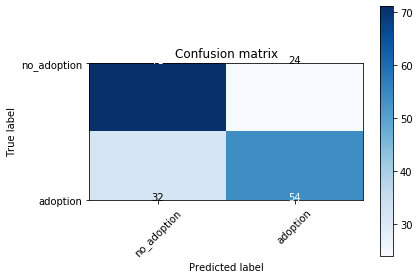

In [16]:
from src.confusion import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, accuracy_score, recall_score, precision_score
plot_confusion_matrix(confusion_matrix(y_val, y_hat_val),classes=['no_adoption', 'adoption'])

In [17]:
print(f'Accuracy Score: {accuracy_score(y_val, y_hat_val)}')
print('-------------------')
print(f'Precision score: {precision_score(y_val, y_hat_val)}')
print('-------------------')
print(f'Recall Score: {recall_score(y_val, y_hat_val)}')
print('-------------------')
print(f'f1_score: {f1_score(y_val, y_hat_val)}')
print('-------------------')
print(f'roc_auc_score{roc_auc_score(y_val, y_hat_val)}')


Accuracy Score: 0.6906077348066298
-------------------
Precision score: 0.6923076923076923
-------------------
Recall Score: 0.627906976744186
-------------------
f1_score: 0.6585365853658537
-------------------
roc_auc_score0.6876376988984089


If you were building a model for the animal shelter, which metric would you focus on?

# 2. Decision Trees at a High Level

The **CART algorithm** is structured as a sequence of questions to try and split up the different observations into their own groups. The result of these questions is a tree like structure where the ends are terminal nodes at which point there are no more questions.  A simple example of a decision tree is as follows:

<img src='./img/titanic_tree.png' width=600/>

A decision tree is a machine learning model that works by partitioning our sample space in a hierarchical way.

How do we partition the space? The key idea is that some attributes provide more information than others when trying to make a decision.

# In Pairs (private message): 
    
You are a triage nurse at a hospital being inundated with patients who believe they are suffering from coronavirus.  You neeed to quickly assess which patients are most likely to have coronavirus, and separate them from the rest of the patients.      

Based on what you know of the virus, create a list of a few questions and a flow chart to help you to quickly decide which patients should be separated.  

In [18]:
from src.student_caller import pairs

pairs(mccalister)

['Jacob' 'Luluva']
['Dann' 'Johnhoy']
['Jason' 'Syd']
['Karim' 'Matt']
['Amanda' 'Chum']
['Maximilian' 'Leana']
['Adam']


## High level of how the Decision Tree algorithm works

* Select the best attribute using Attribute Selection Measures (Gini/Entropy) to split the records.
* Make that attribute a decision node and break the dataset into smaller subsets.
* Starts tree building by repeating this process recursively for each child until one of these conditions will match:
    * You have reached a pure split: the leaf has only 1 class
    * There are no more remaining attributes to split on.
    * There are no more instances.

### Important Terminology related to Decision Trees
Let’s look at the basic terminologies used with Decision trees:

- **Root Node:** It represents entire population or sample and this further gets divided into two or more homogeneous sets.
- **Decision Node:** When a sub-node splits into further sub-nodes, then it is called decision node.
- **Leaf/ Terminal Node:** Nodes with no children (no further split) is called Leaf or Terminal node.
- **Pruning:** When we reduce the size of decision trees by removing nodes (opposite of Splitting), the process is called pruning.
- **Branch / Sub-Tree:** A sub section of decision tree is called branch or sub-tree.
- **Parent and Child Node:** A node, which is divided into sub-nodes is called parent node of sub-nodes where as sub-nodes are the child of parent node.


<img src='./img/decision_leaf.webp' width=600 />

In [19]:
example_sample = df.sample(10, random_state=7)
example_sample.drop('age_in_days',axis=1, inplace=True)
example_sample.reset_index(inplace=True, drop=True)
example_sample.head(10)

,is_dog,is_female,adoption
0,1,1,1
1,0,1,1
2,1,1,1
3,1,1,1
4,1,1,0
5,1,0,0
6,0,1,0
7,0,0,0
8,1,0,0
9,1,1,1


## Partitioning

I partition my data by asking a question about the independent variables. The goal is to ask the right questions in the right order so that the resultant groups are "pure" with respect to the dependent variable. More on this below!

Suppose, for example, that I choose:

### Is the animal a dog?

This would divide my data into two groups:

- Group 1 (Dog = 0):

data points: 1,6,7

- Group 2 (Dog = 1):

data points:  0,2,3,4,5,8,9


#### Key Question: How are the values of the target distributed in this group?

In Group 1, I have: adoption, no adoption, no adoption

In Group 2, I have, in order: adoption, adoption, adoption, no adoption, no adoption, no adoption, adoption

This seems like an ok split:   
  - The first group is majority no adoptions (2/3), so it suggests cats are unlikely to get adopted.   
  - The second group has captured most of the adoptions, but there is only a slight majority of adoptions over no adoptions (4/7)

Would a different question split our data more effectively? Let's try:

### Is the animal female?

Let's look at our splits:

- Group 1 (Female = 0):

data points: 5,7,8

- Group 2 (Female = 1):


data points: 0,1,2,3,4,6,9


In Group 1, I have: no adoption, no adoption, no adoption  
In Group 2, I have: adoption, adoption, adoption, adoption, no adoption, no adoption, adoption

That seems better:  
  - Group 1 is a pure group, no adoption when sex is male
  - Group 2 has 5/7 adoptions.
  
This seems like a much better split.

So a (very simple!) model based on the above sample predicts:  
(i) A female animal will be adopted  
(ii) A male animal will not be adopted  

would perform fairly well.  

But how would my partition be *best* split? And how do I really know that the second split is better than the first? Can I do better than intuition here?  

# 3. Entropy/Information Gain and Gini

The goal is to have our ultimate classes be fully "ordered" (for a binary dependent variable, we'd have the 1's in one group and the 0's in the other). So one way to assess the value of a split is to measure how *disordered* our groups are, and there is a notion of *entropy* that measures precisely this.

The entropy of the whole dataset is given by:

$\large E = -\Sigma^n_i p_i\log_2(p_i)$,

where $p_i$ is the probability of belonging to the $i$th group, where $n$ is the number of groups (i.e. target values).

**Entropy will always be between 0 and 1. The closer to 1, the more disordered your group.**

<img src='./img/Entropy_mapped.png' width=600/>

To repeat, in the present case we have only two groups of interest: adoption and no adoption.

5 out of 10 were adopted and 5 out of 10 were not adopted, so **these are the relevant probabilities** for our calculation of entropy.

So our entropy for the sample above is:

$-0.5*\log_2(0.5) -0.5*\log_2(0.5)$.

Let's use the ``numpy's`` `log2()` function to calculate this:

In [20]:
(-.5) * np.log2(.5) - (.5) * np.log2(.5)

1.0

Now, on your own, calculate the entropy of the training set.

In [21]:
one_random_student(mccalister)

# your code here
def entropy(p0,p1):
    
    "entropy of a dataset with binary outcomes"
    
    entropy = (-p_0)*np.log2(p_0) - p_1*np.log2(p_1)
    return entropy
    


values, counts = np.unique(y_train, return_counts=True)

p_0 = counts[0]/sum(counts)
p_1 = counts[1]/sum(counts)

entropy(p0, p1)

Adam
None


In [22]:
#__SOLUTION__
values, counts = np.unique(y_train, return_counts=True)

print(values)
print(counts)

p_0 = counts[0]/sum(counts)
p_1 = counts[1]/sum(counts)

print(p_0, p_1)

def entropy(p_0,p_1):
    
    "entropy of a dataset with binary outcomes"
    
    entropy = (-p_0)*np.log2(p_0) - p_1*np.log2(p_1)
    return entropy
    
entropy(p_0, p_1)

[0 1]
[373 349]
0.5166204986149584 0.48337950138504154


0.9992027901802841

To calculate the entropy of a *split*, we're going to want to calculate the entropy of each of the groups made by the split, and then calculate a weighted average of those groups' entropies––weighted, that is, by the size of the groups. Let's calculate the entropy of the split produced by our "is our animal a dog" question:

Group 1 (not a dog): adoption, no adoption, no adoption



$E_{g1} = - 2/3 * \log_2(2/3) - 1/3 * \log_2(1/3)$. 

Group 2: adoption, adoption, adoption, no adoption, no adoption, no adoption, adoption  
$E_{g2} = -\frac{3}{7} * \log_2\left(\frac{3}{7}\right) - \frac{4}{7} * \log_2\left(\frac{4}{7}\right)$.




In [24]:
Egc = (-2/3)*np.log2(2/3) - (1/3)*np.log2(1/3)
print(Egc)

Egd =(-3/7)*np.log2(3/7) - (4/7)*np.log2(4/7)
print(Egd)

0.9182958340544896
0.9852281360342515


Now weight those by the probability of each group, and sum them, to find the entropy of the split:

In [25]:
pgc = (3/10) * Egc
pgd = (7/10) * Egd

E_split_d = pgc + pgd
E_split_d

0.965148445440323

Compare that to the male/female question:

In [26]:
# In Group 1: no adoption, no adoption, no adoption  

Egm =  - (3/3)*np.log2(3/3) # This is a pure split, entropy is 0
print(Egm)

# In Group 2, I have: adoption, adoption, adoption, adoption, no adoption, no adoption, adoption

Egf =(-2/7)*np.log2(2/7) - (5/7)*np.log2(5/7) 
print(Egf)



-0.0
0.863120568566631


Weighted sum

In [27]:
pgm = Egm * 3/10
pgf = Egf * 7/10

E_split_f = pgm + pgf
E_split_f

0.6041843979966417

For a given split, the **information gain** is simply the entropy of the parent group less the entropy of the split.

In [28]:
total_entropy_sample = (-5/10)*np.log2(5/10) - (5/10) * np.log2(5/10)


# Information gain, dog or cat

ig_d = total_entropy_sample - E_split_d
print(f"Information gain dog/cat: {ig_d}")

ig_f = total_entropy_sample - E_split_f
print(f"Information gain male/female: {ig_f}")



Information gain dog/cat: 0.034851554559677034
Information gain male/female: 0.3958156020033583


For a given parent, then, we maximize our model's performance by *minimizing* the split's entropy.

What we'd like to do then is:

1. to look at the entropies of all possible splits, and
2. to choose the split with the lowest entropy.

In practice there are far too many splits for it to be practical for a person to calculate all these different entropies ...

... but we can make computers do these calculations for us!

In [29]:
dt = DecisionTreeClassifier(criterion='entropy')
X = example_sample.drop('adoption', axis=1)
y = example_sample.adoption
dtree = dt.fit(X,y)
df.__dict__


{'_is_copy': <weakref at 0x101ac67c8; dead>, '_data': BlockManager
 Items: Index(['is_dog', 'age_in_days', 'is_female', 'adoption'], dtype='object')
 Axis 1: Int64Index([  1,   2,   3,   5,   6,   7,   8,   9,  10,  12,
             ...
             989, 990, 991, 992, 993, 994, 995, 996, 997, 998],
            dtype='int64', name='Unnamed: 0', length=903)
 IntBlock: slice(0, 4, 1), 4 x 903, dtype: int64, '_item_cache': {'adoption': Unnamed: 0
  1      0
  2      1
  3      1
  5      0
  6      1
        ..
  994    1
  995    1
  996    1
  997    1
  998    1
  Name: adoption, Length: 903, dtype: int64}}

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


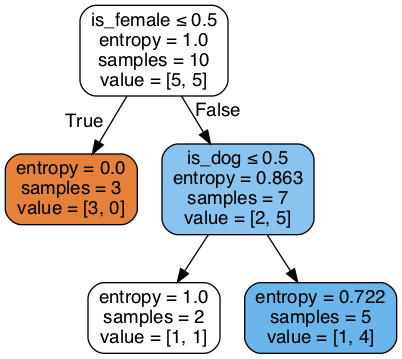

In [30]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, 
               feature_names=X.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Gini Impurity

An alternative metric to entropy comes from the work of Corrado Gini. The Gini Impurity is defined as:

$\large G = 1 - \Sigma_ip_i^2$, or, equivalently, $\large G = \Sigma_ip_i(1-p_i)$.

where, again, $p_i$ is the probability of belonging to the $i$th group.

**Gini Impurity will always be between 0 and 0.5. The closer to 0.5, the more disordered your group.**

# Pairs (3 minutes)

- Calculate the Gini score for both the dog split and the female split.  
- Decide which is best, i.e. which to split on first
- Change the hyperparameter to Gini, and print the tree like above to confirm your work

Group 1 (not a dog): adoption, no adoption, no adoption  
Group 2 (dog): adoption, adoption, adoption, no adoption, no adoption, no adoption, adoption  

In Group 1 (male), I have: no adoption, no adoption, no adoption  
In Group 2 (female), I have: adoption, adoption, adoption, adoption, no adoption, no adoption, adoption

In [31]:
#__SOLUTION__
g1_l = 1 - ((1/3)**2 + (2/3)**2)
g1_r = 1 - ((4/7)**2 + (3/7)**2)

gini_split = 3/10 * g1_l + (7/10) ** 2
gini_split

0.6233333333333333

In [32]:
#__SOLUTION__
g1_l = 1 - ((3/3)**2 + 0)
g1_r = 1 - ((5/7)**2 + (2/7)**2)

gini_split = 3/10 * g1_l + (7/10) ** 2
gini_split
g1_l+g1_r

0.40816326530612246

In [ ]:
#__SOLUTION
dt = DecisionTreeClassifier(criterion='gini')
X = example_sample.drop('adoption', axis=1)
y = example_sample.adoption
dtree = dt.fit(X,y)
df.__dict__

In [ ]:
#__SOLUTION__
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, 
               feature_names=X.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# Caveat


As found in *Introduction to Data Mining* by Tan et. al:

`Studies have shown that the choice of impurity measure has little effect on the performance of decision tree induction algorithms. This is because many impurity measures are quite consistent with each other [...]. Indeed, the strategy used to prune the tree has a greater impact on the final tree than the choice of impurity measure.`

# 4. Issues with Decision Trees

### Decision trees are prone to overfitting

Let's add back in age_in_days and refit the tree


In [33]:

animal_shelter.dropna(subset=['age_upon_outcome'], inplace=True )
df = preprocess_df(animal_shelter)
df.shape

(903, 4)

In [34]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='entropy')
X = df.drop(['adoption'], axis=1)
y = df.adoption
X.head()

,is_dog,age_in_days,is_female
Unnamed: 0,,,
1,0,46,1
2,0,136,1
3,1,575,1
5,0,748,1
6,0,75,0


In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.25)
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, random_state=42, test_size=.25)

In [36]:
dt.fit(X_t,y_t)


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

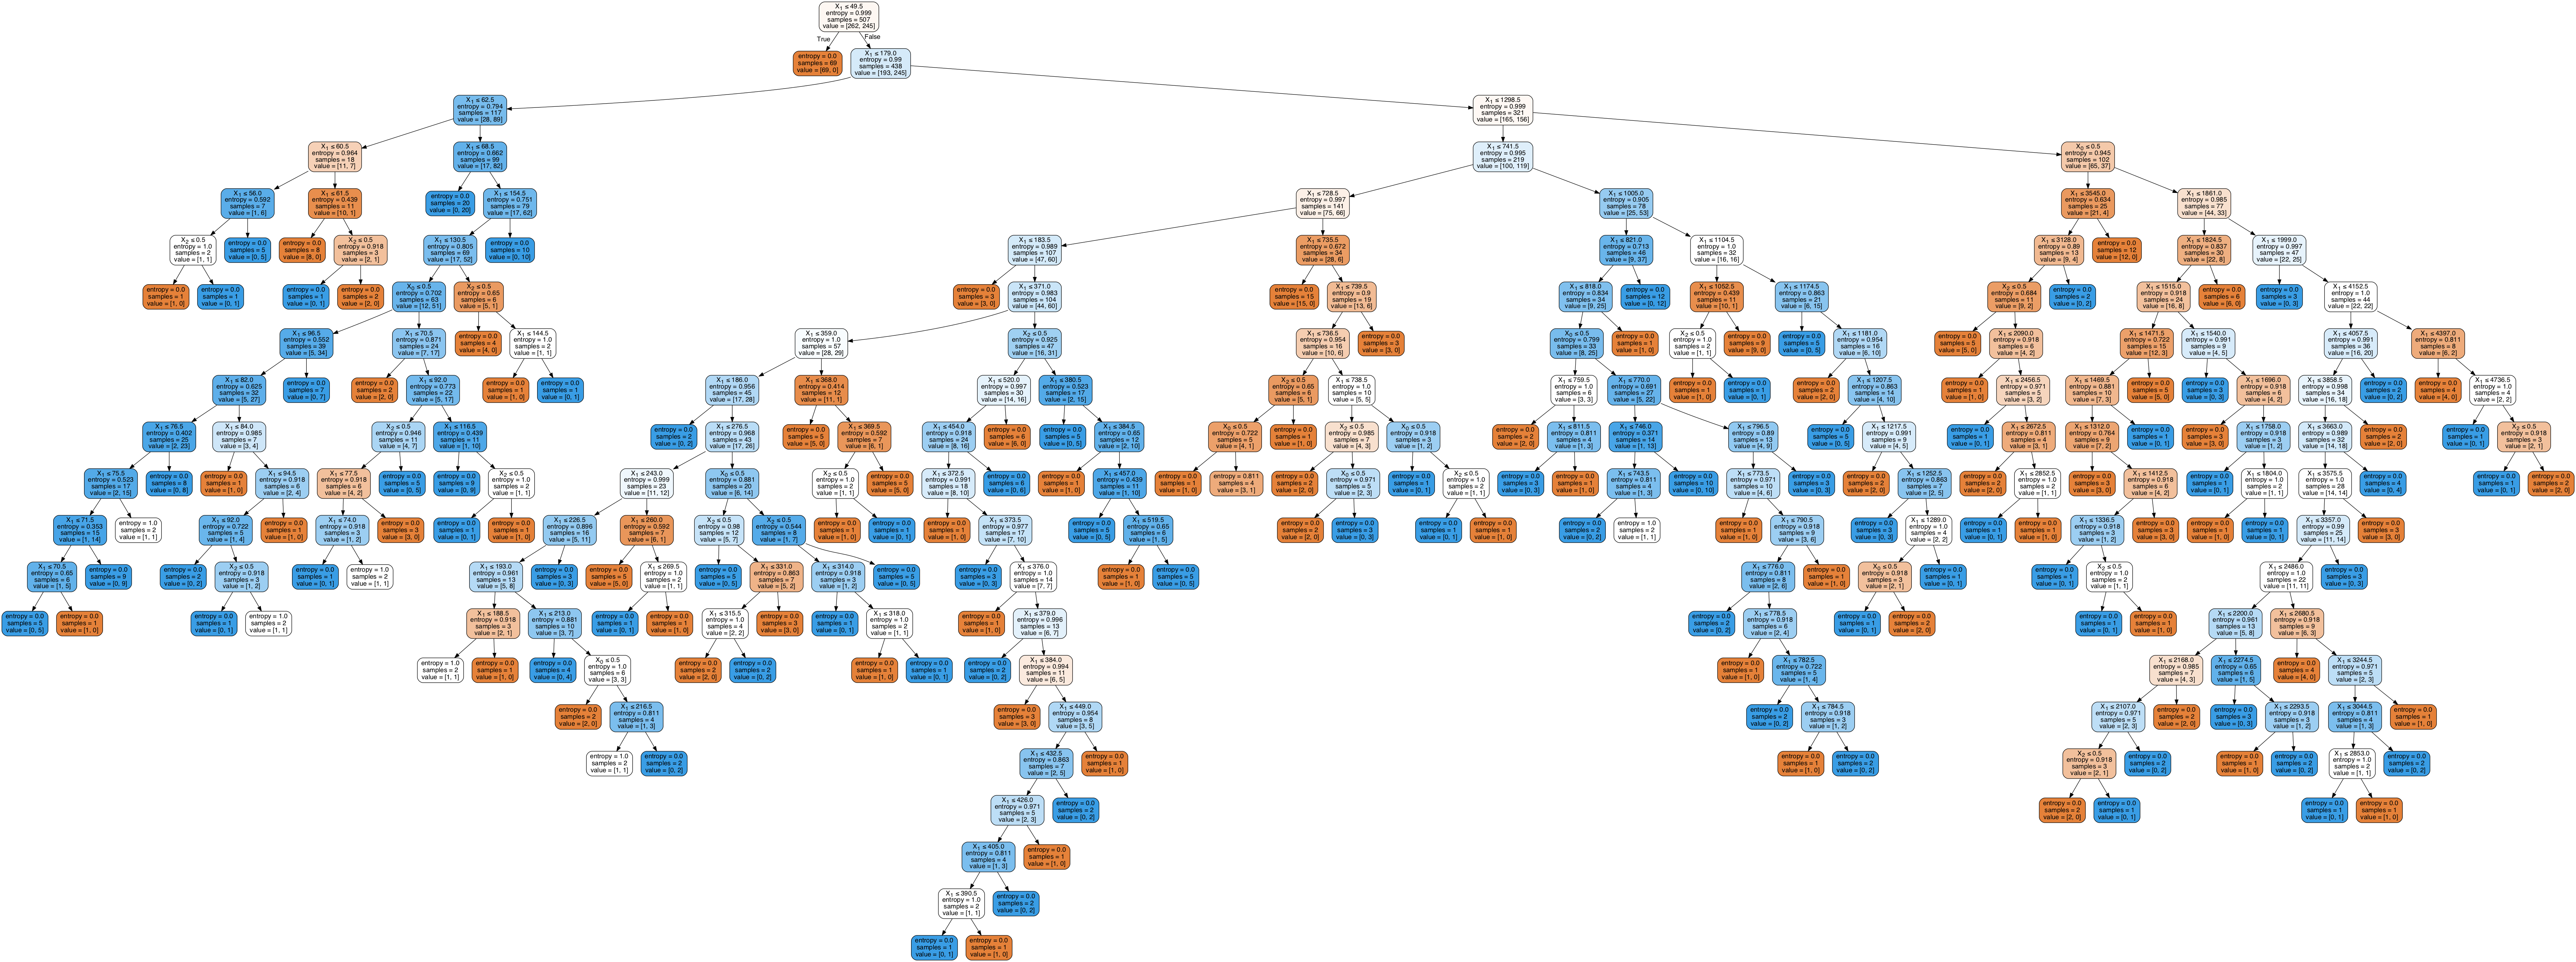

In [37]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

That is a good visual to go represent an overfit tree.  Let's look at the accuracy.

In [38]:
# That is massive
dt.score(X_t,y_t)

0.9861932938856016

That super high accuracy score is a telltale sign of an overfit model.

In [39]:
# That's a bit dropoff
dt.score(X_val, y_val)

0.7176470588235294

### Bias-Variance with Decision Trees

The CART algorithm will repeatedly partition data into smaller and smaller subsets until those final subsets are homogeneous in terms of the outcome variable. In practice this often means that the final subsets (known as the leaves of the tree) each consist of only one or a few data points. 

This results in low-bias, high variance trees.


## Stopping Criterion - Pruning Parameters


The recursive binary splitting procedure described above needs to know when to stop splitting as it works its way down the tree with the training data.

**min_samples_leaf:**  The most common stopping procedure is to use a minimum count on the number of training instances assigned to each leaf node. If the count is less than some minimum then the split is not accepted and the node is taken as a final leaf node.

**max_leaf_nodes:** 
Reduce the number of leaf nodes

**max_depth:**
Reduce the depth of the tree to build a generalized tree
Set the depth of the tree to 3, 5, 10 depending after verification on test data

**min_impurity_split :**
A node will split if its impurity is above the threshold, otherwise it is a leaf.


Let's try limiting the depth:

In [40]:
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_t, y_t)
print(dt.score(X_t, y_t))
print(dt.score(X_val, y_val))


0.7455621301775148
0.6764705882352942


In [41]:
dt = DecisionTreeClassifier(max_depth=8)
dt.fit(X_t, y_t)
print(dt.score(X_t, y_t))
print(dt.score(X_val, y_val))

0.8500986193293886
0.7411764705882353


Let's try limiting minimum samples per leaf:

In [42]:
dt = DecisionTreeClassifier(min_samples_leaf=3)
dt.fit(X_t, y_t)
print(dt.score(X_t, y_t))
print(dt.score(X_val, y_val))

0.8856015779092702
0.7058823529411765


In [43]:
dt = DecisionTreeClassifier(min_samples_leaf=5)
dt.fit(X_t, y_t)
print(dt.score(X_t, y_t))
print(dt.score(X_val, y_val))

0.8461538461538461
0.7294117647058823


## Decision trees are very senstitive to training data

Let's fit two trees that differ only by 1 sample, and look at the difference.

In [44]:
dt = DecisionTreeClassifier(max_depth=5)
X_t_sample_1 = X_t.sample(100, random_state=42)
y_t_sample_1 = y_t[X_t_sample_1.index]

dt.fit(X_t_sample_1, y_t_sample_1)



DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

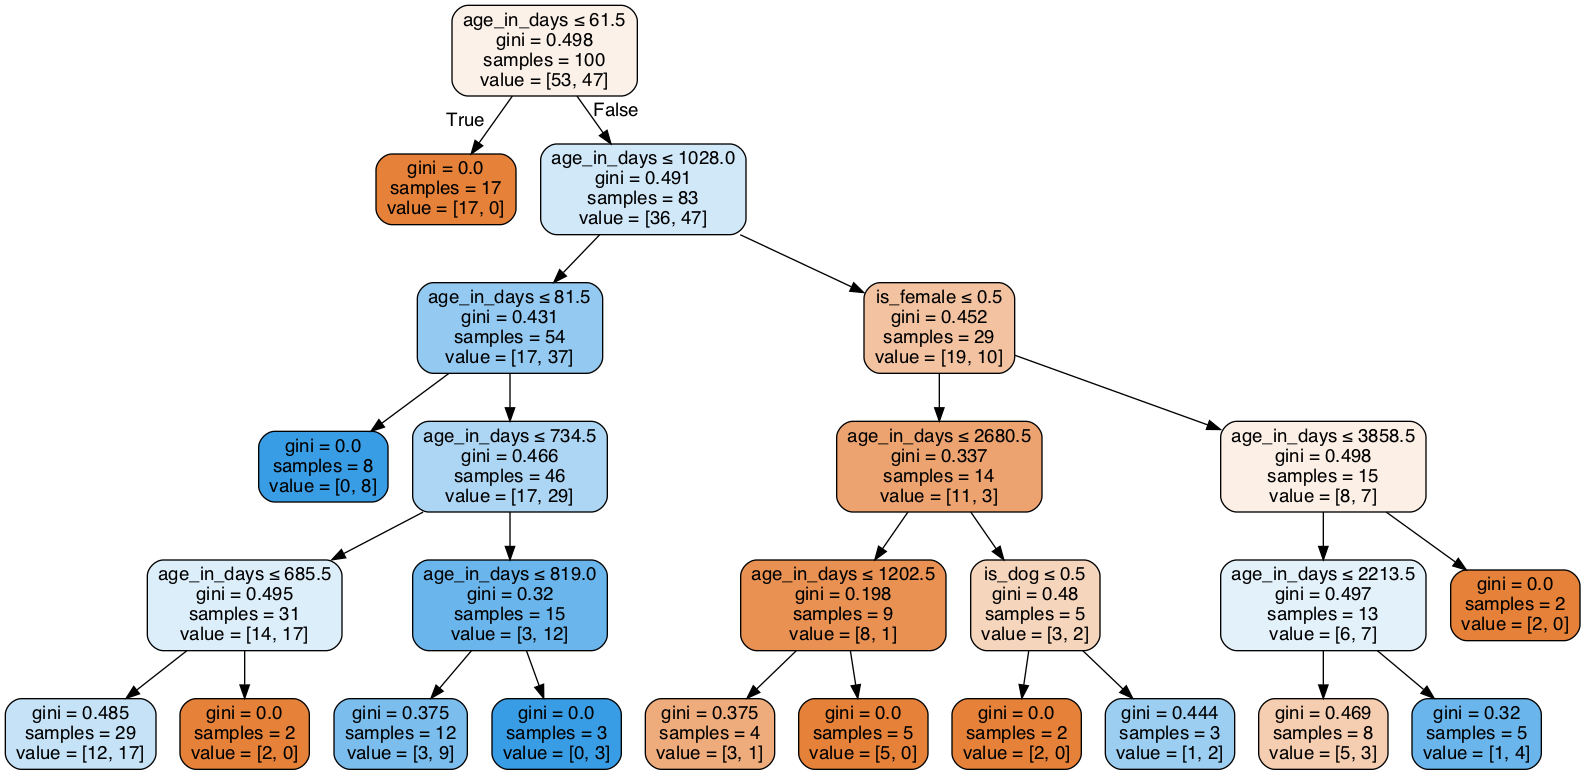

In [45]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, 
               feature_names=X_t.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [46]:
dt = DecisionTreeClassifier(max_depth=5)
X_t_sample_2 = X_t_sample_1.sample(99, random_state=8)
y_t_sample_2 = y_t[X_t_sample_2.index]

dt.fit(X_t_sample_2, y_t_sample_2)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

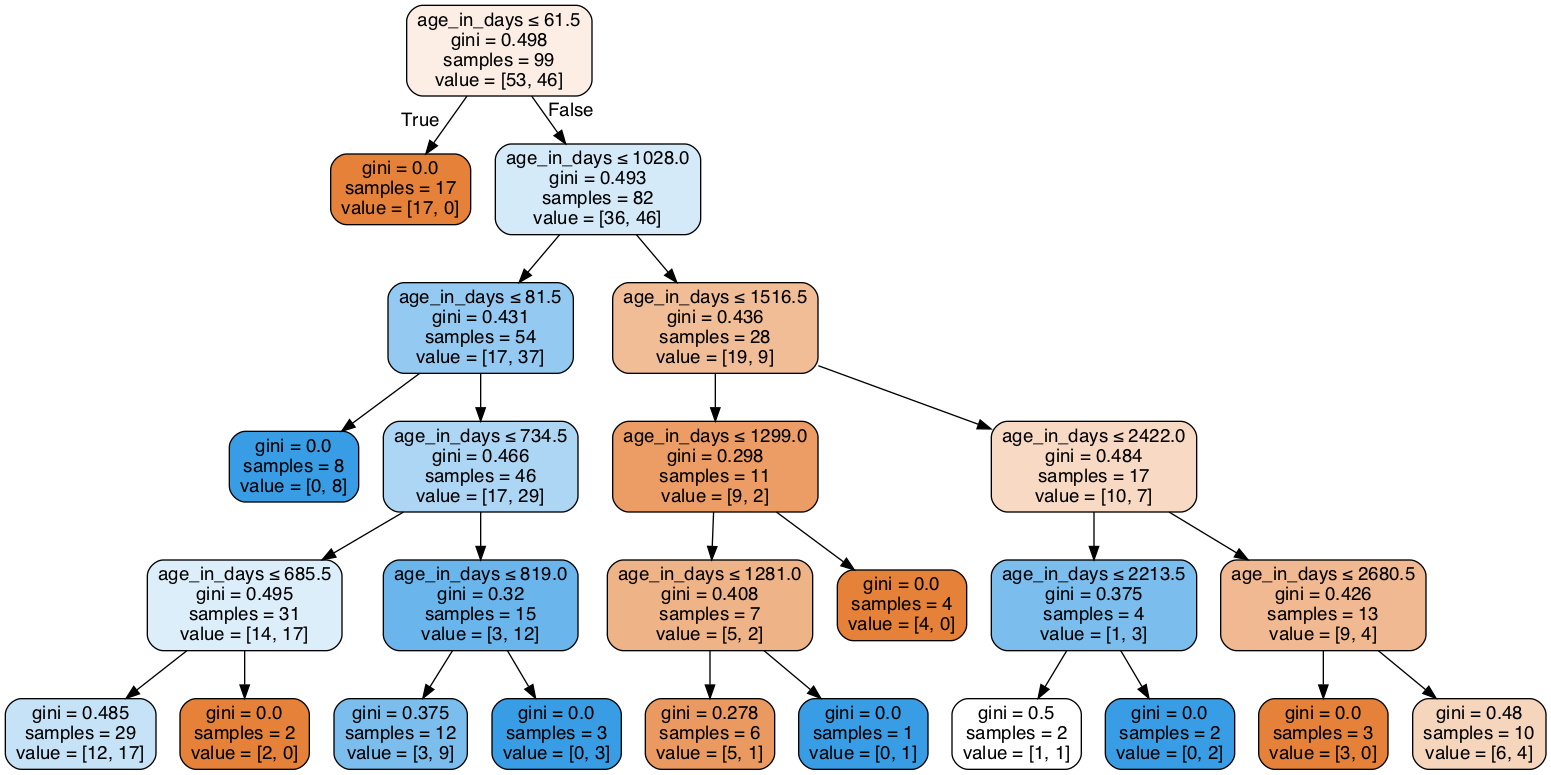

In [47]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                   feature_names=X_t.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Greediness

Decision trees will always split on the features with the most advantageous split. 

Take the above example.  The algorithm never uses the is_dog or is_female columns. This could obscure valuable information held in those variables.  

We will see how to overcome greediness with Random Forests.



## Feature Importances

The fitted tree has an attribute called `ct.feature_importances_`. What does this mean? Roughly, the importance (or "Gini importance") of a feature is a sort of weighted average of the impurity decrease at internal nodes that make use of the feature. The weighting comes from the number of samples that depend on the relevant nodes.

> The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance. [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_)

In [64]:
dt = DecisionTreeClassifier(max_depth=8)
dt.fit(X_t, y_t)


for fi, feature in zip(dt.feature_importances_, X_t.columns):
    print(fi, feature)


0.029307522350746698 is_dog
0.9268435644318476 age_in_days
0.04384891321740575 is_female


More on feature importances [here](https://towardsdatascience.com/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3)

# Conclusions

Decision Tree is a white box type of ML algorithm. It shares internal decision-making logic, which is not available in the black box type of algorithms such as Neural Network. Its training time is faster compared to the neural network algorithm. The decision tree is a non-parametric method, which does not depend upon probability distribution assumptions. Decision trees can handle high dimensional data with good accuracy.

#### Pros
- Decision trees are easy to interpret and visualize.
- It can easily capture non-linear patterns.
- It requires little data preprocessing from the user, for example, there is no need to normalize columns.
- It can be used for feature engineering such as predicting missing values, suitable for variable selection.
- The decision tree has no assumptions about distribution because of the non-parametric nature of the algorithm.

#### Cons
- Sensitive to noisy data. It can overfit noisy data.
- The small variation(or variance) in data can result in the different decision tree. This can be reduced by bagging and boosting algorithms.
- Decision trees are biased with imbalance dataset, so it is recommended that balance out the dataset before creating the decision tree.

# 6. Grid Search

In [61]:
X = df.drop(['adoption'], axis=1)
y = df.adoption

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size = .2)

In [56]:
param_grid = [
  {'criterion': ['gini', 'entropy'], 
   'max_leaf_nodes': list(range(1,10)),
   'max_depth': list(range(2,10))} 
             ]

In [74]:
from sklearn.model_selection import GridSearchCV

In [75]:
search = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=5)
search.fit(X_train, y_train)

ValueError: max_leaf_nodes 1 must be either None or larger than 1

In [76]:
search.best_estimator_

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [77]:
search.best_estimator_.score(X_train, y_train)

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'